# MFI + TIDE + Z

## a) Data Preprocessing

In [ ]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY" ]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2019-01-01 00:00:00",
                                        limit = 1000, update=False)


# Resample from 1hr --> 2h, 3h, 4h, 6h, 12h, 24h, 
from signal_managers import resampler
from signal_managers import indicators

resample_to_list = ["2h", "3h", "4h", "6h", "12h", "24h"]
first_timeframe = "1h"

print(klines_dict.keys())
print(klines_dict['ccxt_kucoin__BTC-USDT'].keys())
# resample_to_list = ["15m", "20m", "30m", "60m"]
# first_timeframe = "5m"
for instrument,instrument_dict in klines_dict.items():
    # print(f"\n{instrument}\n")
    for resample_to in resample_to_list:
        df = instrument_dict[first_timeframe].copy()
        window = int(int(resample_to[:-1])/int(first_timeframe[:-1]))
        # print(f"Resampling {first_timeframe} to {resample_to} --> window: {window}")
        if "m" in resample_to:
            resample_to_formatted = resample_to[:-1]+"T"
        else:
            resample_to_formatted = resample_to
        df_resampled = resampler.calc_klines_resample(df,window=window, resample_to=resample_to_formatted)
        # print(df_resampled.columns)
        klines_dict[instrument][resample_to] = df_resampled


from signal_managers.indicators import calc_tide_strengths
from signal_managers import tide_genetic

print(klines_dict.keys())
print(klines_dict['ccxt_kucoin__BTC-USDT'].keys())
# generate tides for each instruments
instrument_to_trade = "ccxt_kucoin__BTC-USDT"
timeframe_to_trade = "1h"
for instrument in klines_dict.keys():
    for timeframe in klines_dict[list(klines_dict.keys())[0]]:
        timeframe_multiplier = int(timeframe[:-1])/int(timeframe_to_trade[:-1])
        df = klines_dict[instrument][timeframe]
        df = indicators.calc_tides(df,suffix="")
        df = indicators.calc_z_sig(df,cols=['open','high','low','close'], lookback_bars = 24*timeframe_multiplier, threshold = [])
        df=df.dropna()
        from signal_managers import tide_genetic

        # Initialise parent
        tp_position_list = tide_genetic.init_tp_position_parameter_population()
        df0 = tide_genetic.initialise_parent(df)
        df0 = calc_tide_strengths(df0, penalty = 1, tp_position_dict = tp_position_list[0])
        features = ['tide', 'ebb', 'flow', 'sig'] + list(df0.copy().filter(regex="tide").columns)[:-1]
        features = list(set(features))

        tide_parameters_to_test = {"sensitivity":40,
                                "threshold":10,
                                    "windows":[24,36,72],
                                    "SL_penalty":1,
                                    "TPs": tp_position_list[0],
                                }
        sharpe_df, best_df, best_parameter, best_sharpe = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=10)
        # Perform genetic propagation
        best_df[features] = best_df[features].copy().fillna(method='ffill').dropna()
        klines_dict[instrument][timeframe] = best_df
        
        # Join into one DF
        if instrument == instrument_to_trade and timeframe == timeframe_to_trade:
            df_trade = best_df.copy() 

        else:
            df["sharpe"] = best_sharpe["sharpe"].iloc[0]
            df_trade = pd.merge(df_trade, best_df[features].add_prefix(f"{timeframe}_{instrument.split('__')[-1]}_"), left_index=True, right_index=True, how="left")
    


### a) MFI V3

In [ ]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY"]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2018-01-01 00:00:00",
                                        limit = 1000, update=False, verbose=False)

df = klines_dict["ccxt_kucoin__BTC-USDT"]["1h"]#.copy() but memwasteful since can just reload the klines again

In [ ]:
from signal_managers.indicators import calc_mfi_sig
import numpy as np
def dynamic_param_func(x, i):
    """
    Define a more complex function to calculate the window lengths, thresholds, and sensitivity parameters
    based on characteristics of the input data.

    Args:
        x: x is a np_array of cols + dynamic_param_col
        i: The index of the current data point.

    Returns:
        The list of window lengths to use.
        The list of thresholds to use for each window length.
        The sensitivity parameter.
    """
    std = np.std(x[:,-1])

    # Calculate the minimum window length.
    min_window_length = int(std * 10)

    # Calculate the maximum window length.
    max_window_length = int(std * 100)

    # Calculate the number of thresholds to use.

    # Generate a list of possible window lengths.
    window_lengths = np.linspace(min_window_length, max_window_length, num=10)

    return window_lengths

def dynamic_param_func(x, i):
    """
    Define a more complex function to calculate the window lengths, thresholds, and sensitivity parameters
    based on characteristics of the input data.

    Args:
        x: x is a np_array of cols + dynamic_param_col
        i: The index of the current data point.

    Returns:
        The list of window lengths to use.
        The list of thresholds to use for each window length.
        The sensitivity parameter.
    """
    window_lengths = [13]#,21,34,55,89,144]

    return window_lengths


df0= df.copy()
df1 = calc_mfi_sig(df0,
                   cols_set = [['high','low', 'close', 'volume']],
                   MFI_window_threshold_func = dynamic_param_func,
                   dynamic_param_col= ["volume"],
                   fixed_window = False,)
                                

In [ ]:
import importlib
from utils import find_index
importlib.reload(find_index)
from utils.find_index import find_list_index
x = [["open", "high", "low", "close", "volume", "MFI"],["cat","dog", "MFI"]]
find_list_index(x, "cat")

## b) Primary Indicators

### i) MFI signal V3

In [ ]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY"]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2018-01-01 00:00:00",
                                        limit = 1000, update=False, verbose=False)

df = klines_dict["ccxt_kucoin__BTC-USDT"]["1h"]#.copy() but memwasteful since can just reload the klines again

In [ ]:
import importlib
from signal_managers import indicators
importlib.reload(indicators)

from signal_managers.indicators import calc_mfi_sig, param_func_mfi_EMAVol, param_func_mfi

dfm= df.copy()
dfm = calc_mfi_sig(dfm,
                    cols_set=[['open','high','low']],
                     param_func_mfi= param_func_mfi,
                     dynamic_param_col = ["volume"],
                     fixed_window = True)

### ii) Tide signal V3

In [ ]:
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY"]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2018-01-01 00:00:00",
                                        limit = 1000, update=False, verbose=False)

df = klines_dict["ccxt_kucoin__BTC-USDT"]["1h"]#.copy() but memwasteful since can just reload the klines again

In [ ]:
import importlib
from signal_managers import indicators
importlib.reload(indicators)
from signal_managers.indicators import calc_tide_sig, param_func_tide_EMAVol, param_func_tide


dft= df.copy()
dft = calc_tide_sig(dft,
                    cols_set=[['open','high','low']],
                    #  param_func_tide= param_func_tide,        # 16s
                     param_func_tide= param_func_tide,   # 16
                     dynamic_param_col = ["volume"])

In [ ]:
from utils import pickle_helper
pickle_helper.pickle_this(data=dft, pickle_name="df_tide_backtest", path = "database/backtest_dfs/")
dft = pickle_helper.pickle_this(pickle_name="df_tide_backtest", path = "database/backtest_dfs/")

In [ ]:
from backtesters import backtest
# ============================
# Backtest parameters
# ============================


dft1 = dft.copy()
signals = dft1.filter(regex="tide").columns
fee = 0.0001
# fee = 0
slippage = 0.0

min_holding_period = 0
max_holding_period = 1e6

long_equity = 5e5
long_notional=5e5
short_equity = 5e5
short_notional= 5e5

signal_function="default"
figsize = (20,15) #(20,29) # width, height
model_name= "Trend_Following"


tradable_times = [["00:00", "23:00"]]
closing_session_times= [["23:0", "00:00"]]



timeframe = "1h"
sig_timeframe = f"1h"
kline_to_trade = f"close"
volume_to_trade= f"volume"
sig_lag = 0


title = f"{timeframe} BTC Tide spot | fees: {fee*1e4} bps"
file_name = f"{timeframe} BTC Tide"
# signal = "ES_USD_close_sig" 
window = ["2021-01-01","2023-03-31"] 
dft2 = dft1.copy()
if signal_function == "default":
        dft2["sig"] = dft2[signals]#.shift(-1).fillna(method="ffill")
dft3 = dft2[window[0]:window[1]].copy()

signals = dft3.columns
dft_backtested,dft_trades,dft_summary = backtest.backtest(model_name= model_name,
                                                df0=dft3,
                                                timeframe=timeframe,
                                                kline_to_trade=kline_to_trade,
                                                volume_to_trade = volume_to_trade,
                                                tradable_times = tradable_times,
                                                closing_session_times = closing_session_times,
                                                position_sizing_to_trade=None,
                                                min_holding_period=min_holding_period,#/int(timeframe[:-1]),
                                                max_holding_period=max_holding_period,#/int(timeframe[:-1]),
                                                fee=fee,
                                                sig_lag=sig_lag,
                                                slippage=slippage,
                                                long_equity = long_equity,
                                                short_equity = short_equity,
                                                long_notional=long_notional,
                                                short_notional=short_notional,
                                                signals=signals, 
                                                signal_function=signal_function, 
                                                figsize=figsize, # width, height
                                                show_B=True,
                                                show_LS=True,
                                                title=title,
                                                file_name=file_name,
                                                plots=True,
                                                diagnostics_verbose=False,
                                                trail_SL = None,
                                                trail_TP = None,
                                                trail_increment = None,
                                                N=365*24
                                                )

df = dft_backtested.copy()

### ii) Z signal V3

In [ ]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY"]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2018-01-01 00:00:00",
                                        limit = 1000, update=False, verbose=False)

df = klines_dict["ccxt_kucoin__BTC-USDT"]["1h"]#.copy() but memwasteful since can just reload the klines again

In [ ]:
import importlib
from signal_managers import indicators
importlib.reload(indicators)

import numpy as np
from signal_managers.indicators import calc_z_sig, param_func_Z_EMAVol, param_func_Z

dfz = calc_z_sig(df,
                #  cols_set=[['open'],['high'],['low'],['close']],
                 cols_set=[["close"]],
                 param_func_Z = param_func_Z_EMAVol,
                #  param_func_Z = param_func_Z,
                 dynamic_param_col= ["volume"],
                 dynamic_param_combine = True,)

In [ ]:
from backtesters import backtest
# ============================
# Backtest parameters
# ============================

from utils import pickle_helper
pickle_helper.pickle_this(data=dfz, pickle_name="df_z_backtest", path = "database/backtest_dfs/")
dfz = pickle_helper.pickle_this(pickle_name="df_z_backtest", path = "database/backtest_dfs/")


df = dfz.copy()
signals = list(df.filter(regex="sig").columns)[0]
fee = 0.0001
# fee = 0
slippage = 0.0

min_holding_period = 24
max_holding_period = 1e6

long_equity = 5e5
long_notional=5e5
short_equity = 5e5
short_notional= 5e5

signal_function="z_sig"
figsize = (20,15) 
model_name= "Trend_Following"



tradable_times = None #[["00:05", "23:50"]]
closing_session_times= None #[["23:50", "00:00"]]


# timeframes only used by backtest_summary
timeframe = "1h"

# This points to cols in df for trade
kline_to_trade = f"close"
volume_to_trade= f"volume"
sig_lag = 0 # this 


title = f"{timeframe} BTC Z spot | fees: {fee*1e4} bps"
file_name = f"{timeframe} BTC Tide"
# signal = "ES_USD_close_sig" 
window = ["2021-01-01","2023-03-31"] 
df_sig = df.copy()
df_sig["sig"] = df_sig[signals]#.shift(-1).fillna(method="ffill")
df_trade = df_sig[window[0]:window[1]].copy()
signals= ["sig",signals]
df_backtested,df_trades,df_summary = backtest.backtest(model_name= model_name,
                                                df0=df_trade,
                                                timeframe=timeframe,
                                                kline_to_trade=kline_to_trade,
                                                volume_to_trade = volume_to_trade,
                                                tradable_times = tradable_times,
                                                closing_session_times = closing_session_times,
                                                position_sizing_to_trade=None,
                                                min_holding_period=min_holding_period,#/int(timeframe[:-1]),
                                                max_holding_period=max_holding_period,#/int(timeframe[:-1]),
                                                sig_lag=sig_lag,
                                                fee=fee,
                                                slippage=slippage,
                                                long_equity = long_equity,
                                                short_equity = short_equity,
                                                long_notional=long_notional,
                                                short_notional=short_notional,
                                                signals=signals, 
                                                signal_function=signal_function, 
                                                figsize=figsize, # width, height
                                                show_B=True,
                                                show_LS=True,
                                                title=title,
                                                file_name=file_name,
                                                plots=True,
                                                diagnostics_verbose=False,
                                                trail_SL = None,
                                                trail_TP = None,
                                                trail_increment = None,
                                                N=365*24
                                                )

df = df_backtested.copy()

## c) Combining MFI with Tide

In [ ]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"

instruments =  ["ccxt_kucoin__BTC-USDT",
                "ccxt_kucoin__ETH-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY"]
timeframes = ["1h"]
instrument_to_trade = instruments[0]


kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2018-01-01 00:00:00",
                                        limit = 1000, update=False, verbose=False)

df = klines_dict[instrument_to_trade]["1h"]#.copy() but memwasteful since can just reload the klines again

In [ ]:
import numpy as np
import importlib
from signal_managers import indicators
importlib.reload(indicators)
import time

from utils.list_type_converter import convert_to_type,convert_to_array
from signal_managers.indicators import calc_mfi_sig, param_func_mfi_EMAVol, param_func_mfi
from signal_managers.indicators import calc_tide_sig, calc_tide_sig, param_func_tide_EMAVol, param_func_tide
from signal_managers.indicators import calc_z_sig, param_func_Z_EMAVol, param_func_Z
dfm= df.copy()
print("-> Initialise feature generation ...")




start = time.time()
print(f"\n{'='*30}\MFI\n{'='*30}")
dfm = calc_mfi_sig(dfm,
                    cols_set=[['open','high','low']],
                     param_func_mfi= param_func_mfi,
                     dynamic_param_col = ["volume"],
                     fixed_window = True)
end = time.time()
print(f"---> Time taken (MFI): {np.round(end-start,3)} seconds\n")




start = time.time()
print(f"\n{'='*30}\nTIDE\n{'='*30}")
# CUSTOM PARAM FUNC ================================================
def param_func_tide_MFI(x,i, col_index = 0):
    q_Lb, q_Ls, q_Sb, q_Ss = 0.9, 0.1, 0.1, 0.9
    # print(col_index)
    # mfi = x[i+1-14:i+1,col_index[0]]
    mfi = x[-1,col_index[0]]
    # print(mfi)
    if 80 >= mfi:
        windows = [[8,13, 21]]
        thresholds = [5]
        sensitivity = [0.95]
    elif mfi <= 20:
        windows = [[5,8,13]]
        thresholds = [7]
        sensitivity = [0.9]
    else:
        windows = [[5, 20, 67]]
        thresholds = [10]
        sensitivity = [0.5]
    return convert_to_array(windows), convert_to_type(thresholds, int), convert_to_type(sensitivity, float) 
# CUSTOM PARAM FUNC ================================================

dfmt = calc_tide_sig(dfm,
                    cols_set=[['open','high','low']],
                     param_func_tide= param_func_tide_MFI,
                     dynamic_param_col = ["MFI"])
end = time.time()
print(f"---> Time taken : {np.round(end-start,3)} seconds\n")




start = time.time()
print(f"\n{'='*30}\Z\n{'='*30}")
# CUSTOM PARAM FUNC ================================================
def param_func_Z_tide(x,i, col_index = 0):
    q_Lb, q_Ls, q_Sb, q_Ss = 0.9, 0.1, 0.1, 0.9

    # mfi = x[i+1-14:i+1,col_index[0]]
    tide = x[-1,col_index[0]]
    # print(mfi)
    if tide == 1:
        windows = [24]
        thresholds = [1.5]
    else:
        windows = [288]
        thresholds = [2]
    return convert_to_array(windows), convert_to_type(thresholds, int)
# CUSTOM PARAM FUNC ================================================
dfmtz = calc_z_sig(dfmt,
                #  cols_set=[['open'],['high'],['low'],['close']],
                 cols_set=[["close"]],
                 param_func_Z = param_func_Z_tide,
                #  param_func_Z = param_func_Z,
                 dynamic_param_col= ["tide"],
                 dynamic_param_combine = True,)
end = time.time()
print(f"Time taken (z): {np.round(end-start,3)} seconds\n")


In [ ]:
from backtesters import backtest
# ============================
# Backtest parameters
# ============================

from utils import pickle_helper
pickle_helper.pickle_this(data=dfmtz, pickle_name="dfmtz_backtest", path = "database/backtest_dfs/")
dfmtz = pickle_helper.pickle_this(pickle_name="dfmtz_backtest", path = "database/backtest_dfs/")


df = dfmtz.copy()
signals = list(df.filter(regex="sig").columns)[0]
fee = 0.0001
# fee = 0
slippage = 0.0

min_holding_period = 23
max_holding_period = 1e6

long_equity = 5e5
long_notional=5e5
short_equity = 5e5
short_notional= 5e5

signal_function="z_sig"
figsize = (20,15) 
model_name= "Trend_Following"



tradable_times = None #[["00:05", "23:50"]]
closing_session_times= None #[["23:50", "00:00"]]


# timeframes only used by backtest_summary
timeframe = "1h"

# This points to cols in df for trade
kline_to_trade = f"close"
volume_to_trade= f"volume"
sig_lag = 0 # this 


title = f"{timeframe} {instrument_to_trade} Tide Z spot | fees: {fee*1e4} bps"
file_name = f"{timeframe} {instrument_to_trade} Tide Z"
# signal = "ES_USD_close_sig" 
window = ["2021-01-01","2023-03-31"] 
window = ["2023-03-31","2023-12-31"] 
# window = ["2021-01-01","2023-12-31"]
df_sig = df.copy()
df_sig["sig"] = df_sig[signals]#.shift(-1).fillna(method="ffill")
df_trade = df_sig[window[0]:window[1]].copy()
signals= ["sig",signals]
df_backtested,df_trades,df_summary = backtest.backtest(model_name= model_name,
                                                df0=df_trade,
                                                timeframe=timeframe,
                                                kline_to_trade=kline_to_trade,
                                                volume_to_trade = volume_to_trade,
                                                tradable_times = tradable_times,
                                                closing_session_times = closing_session_times,
                                                position_sizing_to_trade=None,
                                                min_holding_period=min_holding_period,#/int(timeframe[:-1]),
                                                max_holding_period=max_holding_period,#/int(timeframe[:-1]),
                                                sig_lag=sig_lag,
                                                fee=fee,
                                                slippage=slippage,
                                                long_equity = long_equity,
                                                short_equity = short_equity,
                                                long_notional=long_notional,
                                                short_notional=short_notional,
                                                signals=signals, 
                                                signal_function=signal_function, 
                                                figsize=figsize, # width, height
                                                show_B=True,
                                                show_LS=True,
                                                title=title,
                                                file_name=file_name,
                                                plots=True,
                                                diagnostics_verbose=False,
                                                trail_SL = None,
                                                trail_TP = None,
                                                trail_increment = None,
                                                N=365*24
                                                )

df = df_backtested.copy()

## d) 3 layer convolution neural network. Layers: MFI, Tide, Z

In [1]:
from signal_managers.mfi_tide_z_signals import load_klines
instruments =  [
                "ccxt_kucoin__BTC-USDT",
                # "ccxt_kucoin__ETH-USDT",
                "ccxt_currencycom__US500",
                #  "ccxt_currencycom__DXY",
                #  "ccxt_currencycom__Gold",
                #  "ccxt_currencycom__Oil - Crude",
                #   "ccxt_currencycom__NVDA",
                #    "ccxt_currencycom__UVXY"
                ]
timeframes = ["1h"]
instruments_dict = load_klines(instruments = instruments, timeframes=timeframes)


In [2]:
# Resample from 1hr --> 2h, 3h, 4h, 6h, 12h, 24h, 
from signal_managers.mfi_tide_z_signals import resample_instruments_dict

instruments_dict = resample_instruments_dict(instruments_dict,
                                             resample_to_list = ["2h", "3h", "4h", "6h", "12h", "24h"],
                                             first_timeframe = "1h")

In [3]:
import importlib
from signal_managers import mfi_tide_z_signals
importlib.reload(mfi_tide_z_signals)
from signal_managers.mfi_tide_z_signals import calc_mfi_tide_z_signals
sig_dicts = calc_mfi_tide_z_signals(instruments_dict,chosen_to_debug=[])

---> ccxt_kucoin__BTC-USDT 1h : Initialise feature generation ...


  0%|          | 0/1 [00:00<?, ?it/s]

d:\PycharmProjects\quant_experiments\signal_managers\indicators.py:305: RuntimeWarning: invalid value encountered in divide
  mfi = np.where(denominator != 0, numerator/denominator, fill_value)
100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


---> ccxt_kucoin__BTC-USDT 2h : Initialise feature generation ...


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


---> ccxt_kucoin__BTC-USDT 3h : Initialise feature generation ...


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


---> ccxt_kucoin__BTC-USDT 4h : Initialise feature generation ...


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


---> ccxt_kucoin__BTC-USDT 6h : Initialise feature generation ...


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


---> ccxt_kucoin__BTC-USDT 12h : Initialise feature generation ...


100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


---> ccxt_currencycom__US500 1h : Initialise feature generation ...


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


---> ccxt_currencycom__US500 2h : Initialise feature generation ...


  0%|          | 0/1 [00:00<?, ?it/s]d:\PycharmProjects\quant_experiments\signal_managers\indicators.py:305: RuntimeWarning: invalid value encountered in divide
  mfi = np.where(denominator != 0, numerator/denominator, fill_value)
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


---> ccxt_currencycom__US500 3h : Initialise feature generation ...


  0%|          | 0/1 [00:00<?, ?it/s]d:\PycharmProjects\quant_experiments\signal_managers\indicators.py:305: RuntimeWarning: invalid value encountered in divide
  mfi = np.where(denominator != 0, numerator/denominator, fill_value)
100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


---> ccxt_currencycom__US500 4h : Initialise feature generation ...


  0%|          | 0/1 [00:00<?, ?it/s]d:\PycharmProjects\quant_experiments\signal_managers\indicators.py:305: RuntimeWarning: invalid value encountered in divide
  mfi = np.where(denominator != 0, numerator/denominator, fill_value)
100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


---> ccxt_currencycom__US500 6h : Initialise feature generation ...


  0%|          | 0/1 [00:00<?, ?it/s]d:\PycharmProjects\quant_experiments\signal_managers\indicators.py:305: RuntimeWarning: invalid value encountered in divide
  mfi = np.where(denominator != 0, numerator/denominator, fill_value)
100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


---> ccxt_currencycom__US500 12h : Initialise feature generation ...


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


In [4]:
from signal_managers import composite_signals
importlib.reload(composite_signals)
from signal_managers.composite_signals import merge_sig_dicts

instrument_to_trade = "ccxt_kucoin__BTC-USDT"
timeframe_to_trade = "1h"

df_to_trade = merge_sig_dicts(sig_dicts, 
                    instrument_to_trade = instrument_to_trade,
                    timeframe_to_trade = timeframe_to_trade,
                    reduce_col_names = True)


(1) Generate base z-signal to backtest so that can generate positions taken



100%|██████████| 23176/23176 [00:00<00:00, 520214.01it/s]



--------------------
---> (2) TP based strategy 
--------------------



100%|██████████| 23176/23176 [00:00<00:00, 661674.00it/s]


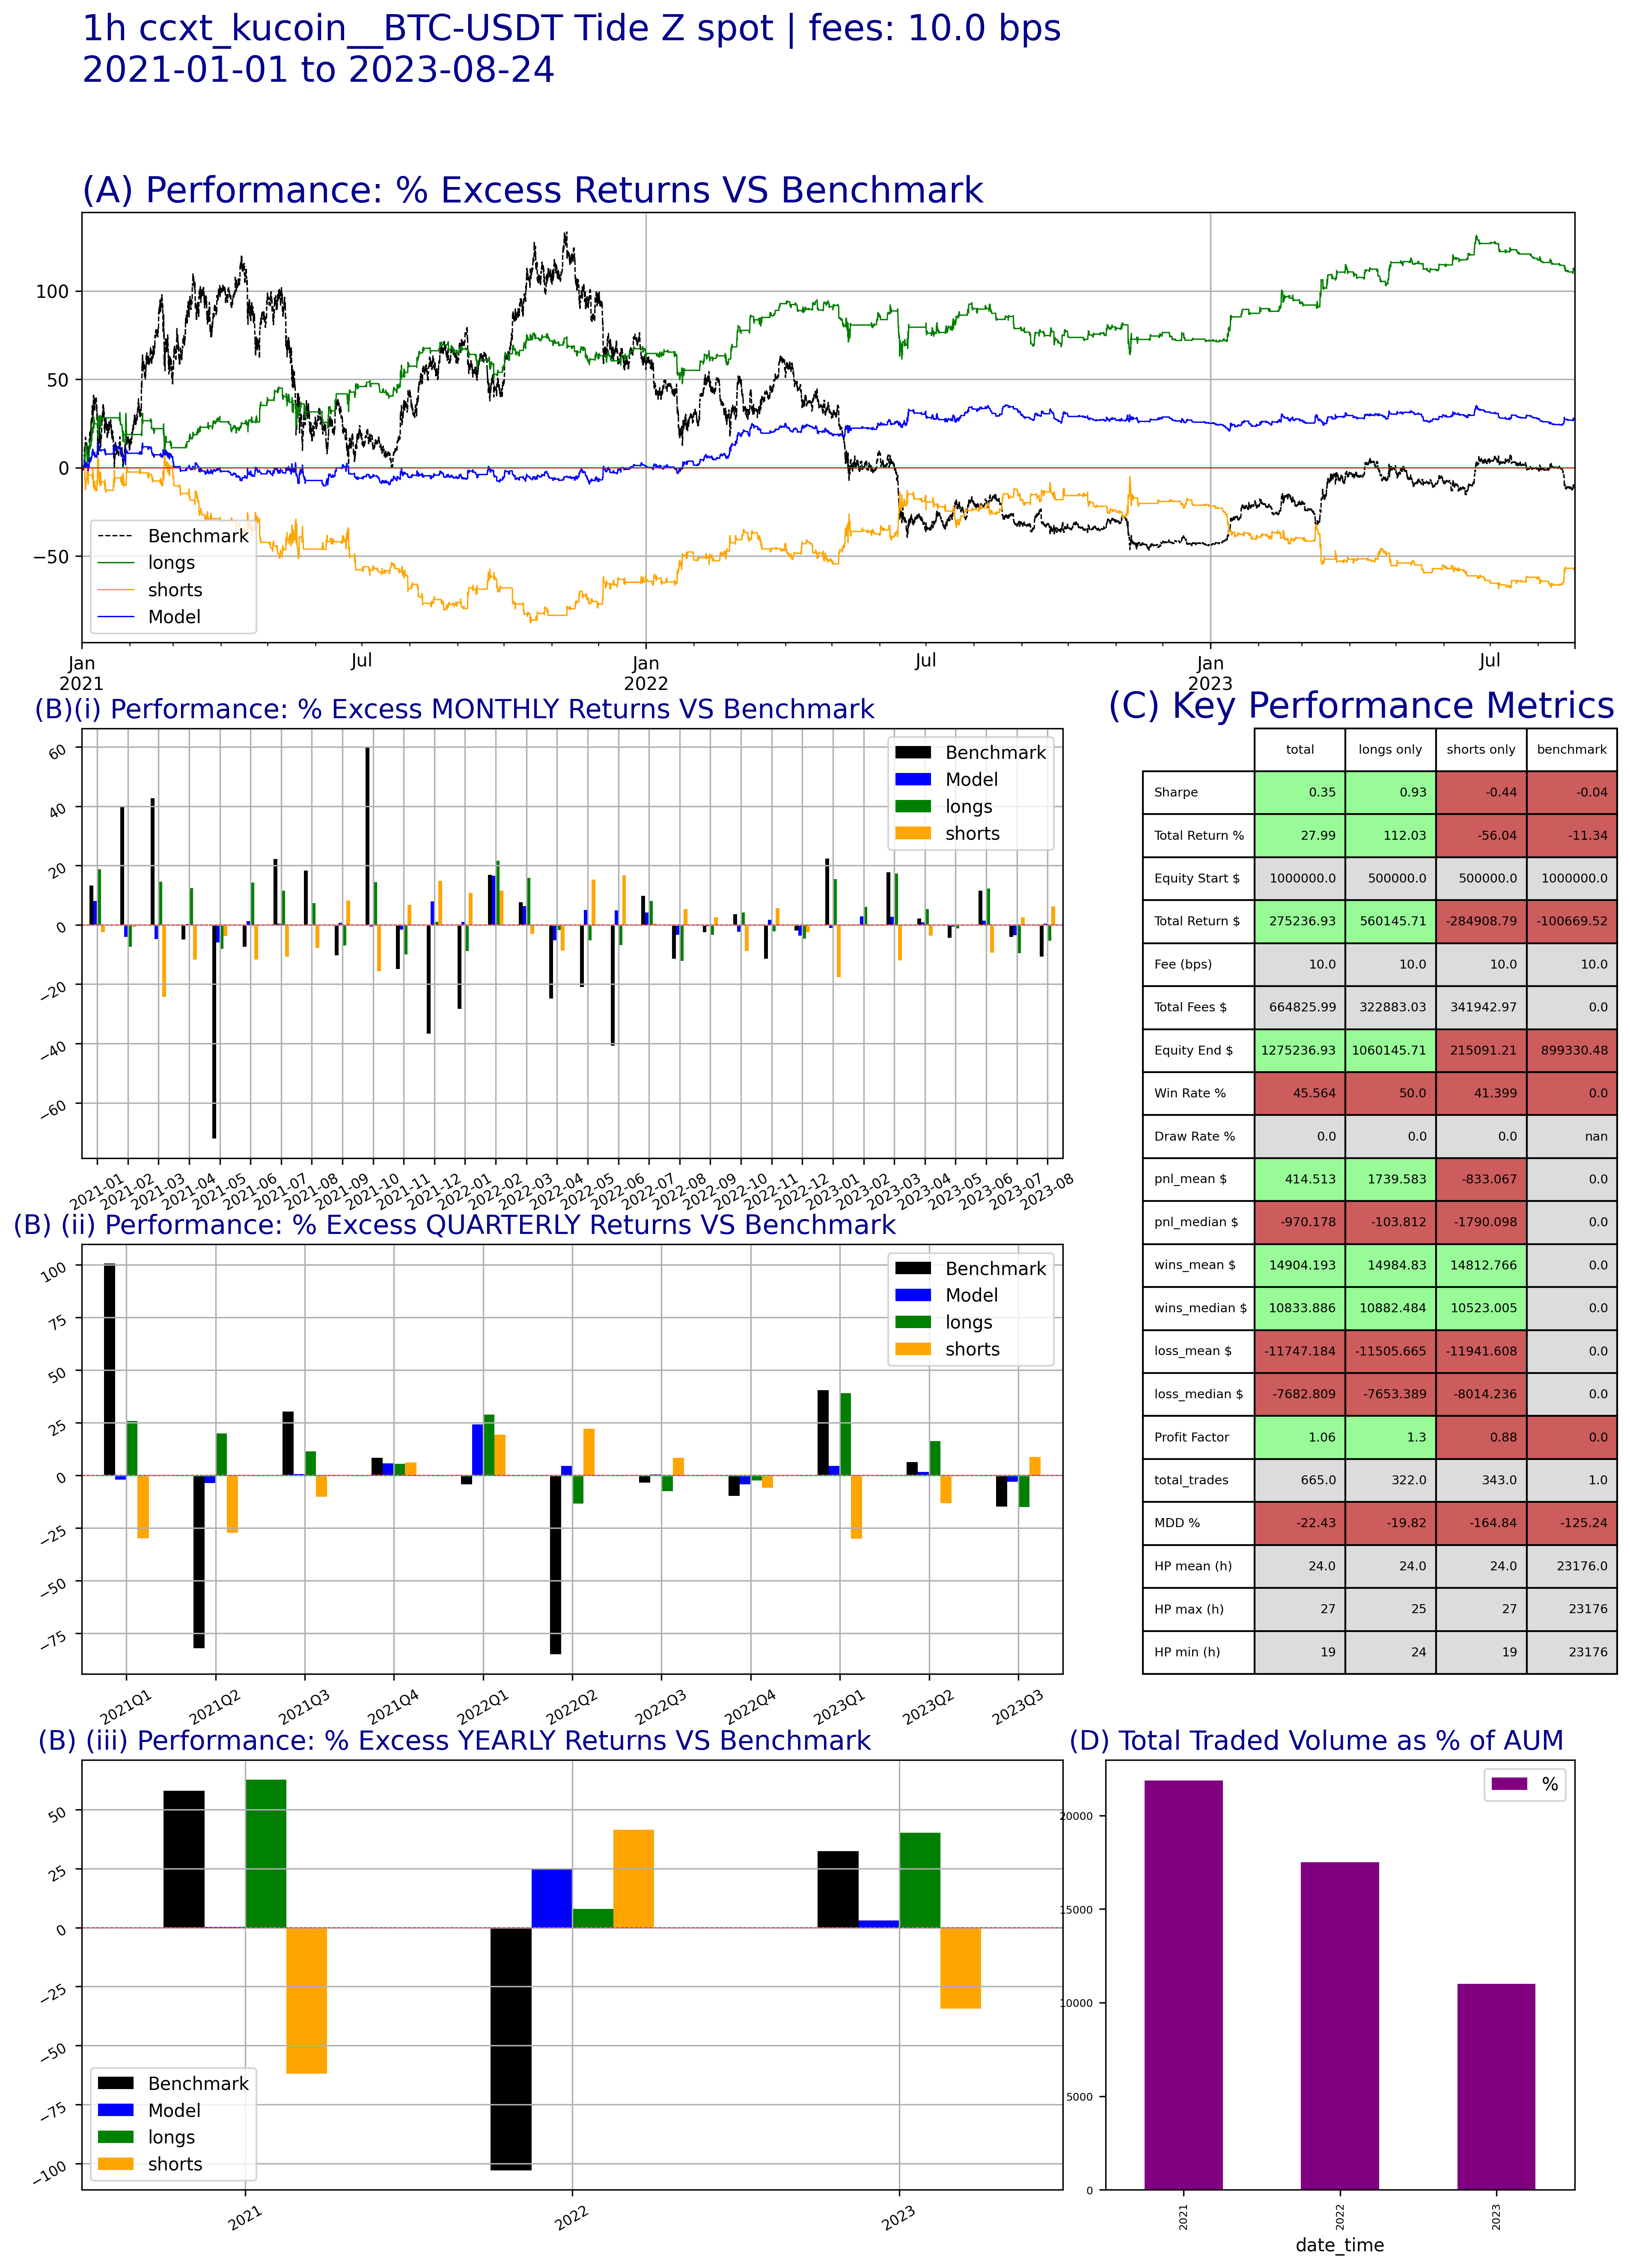

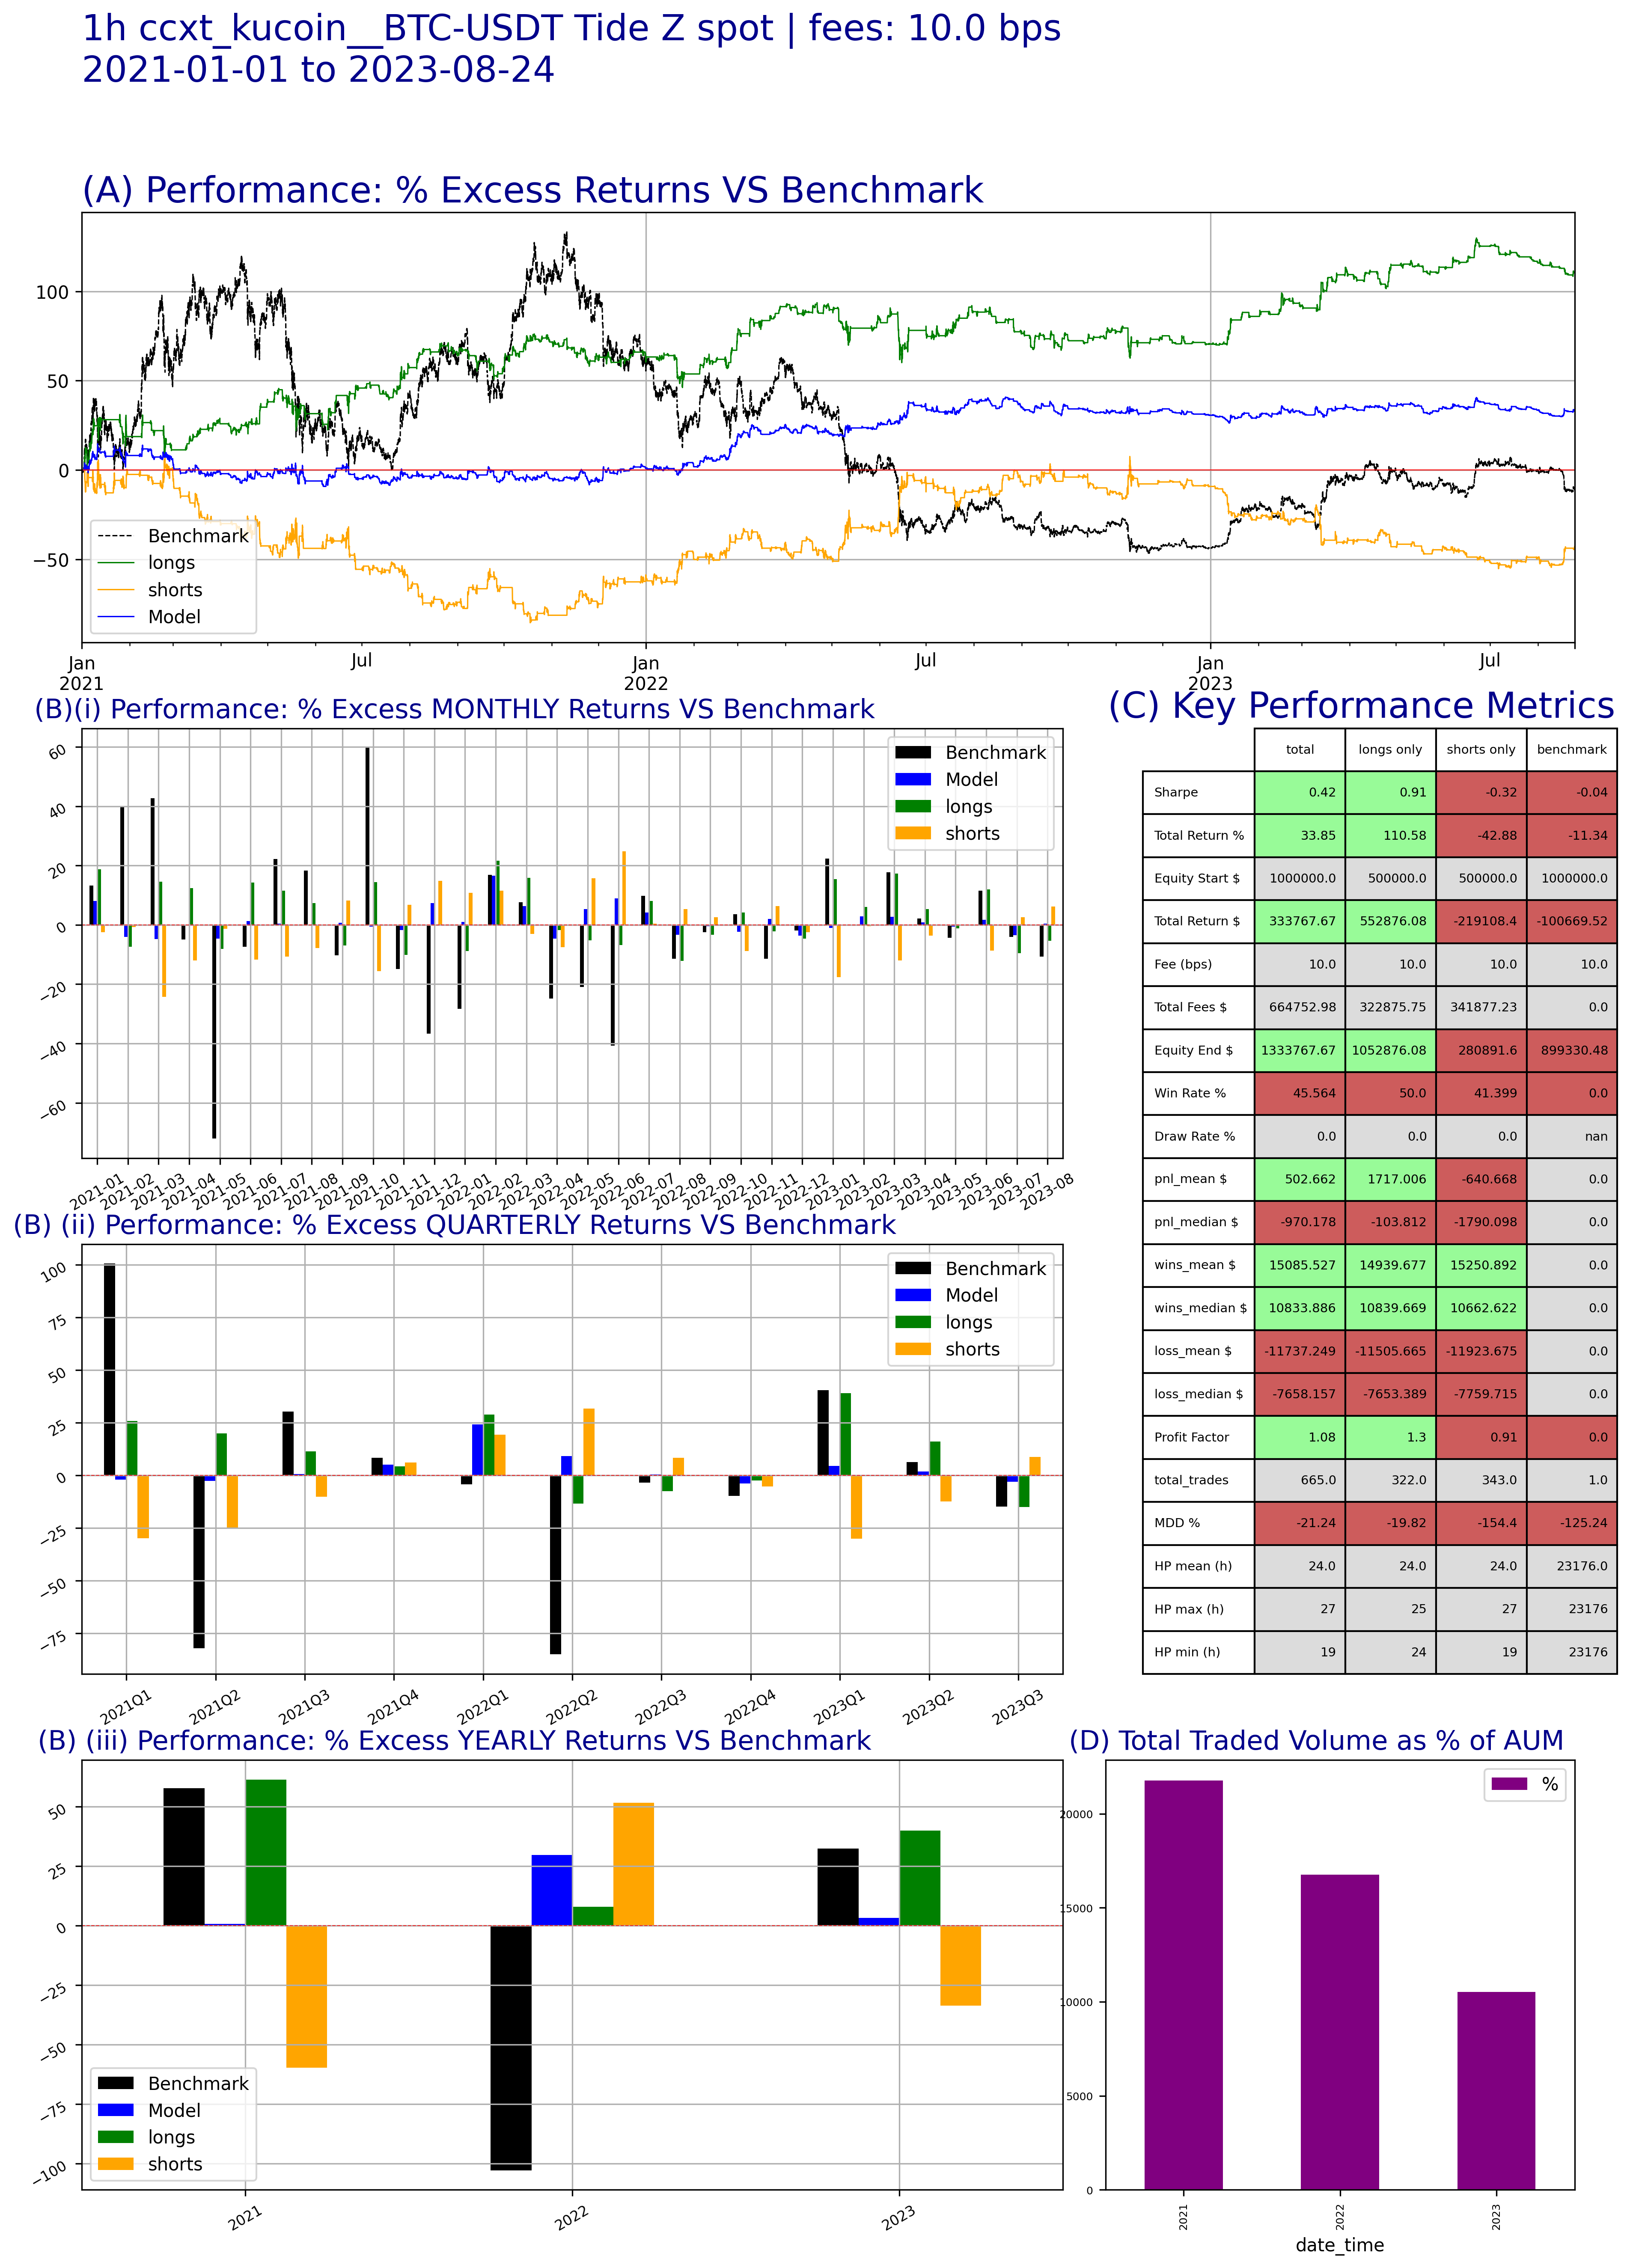

In [34]:

import importlib
from signal_managers import tide_z_genetic
from models import Trend_Following
from backtesters import backtest
importlib.reload(backtest)
importlib.reload(Trend_Following)
importlib.reload(tide_z_genetic)
from signal_managers.tide_z_genetic import objective_function

df_backtested, df_trades, df_summary = objective_function(df_to_trade,
                                                          backtest_window = ["2021-01-01","2023-12-31"],
                                                          instrument_to_trade = "ccxt_kucoin__BTC-USDT",
                                                          timeframe_to_trade = "1h",
                                                          signal_function = "z_sig",
                                                          signals_to_trade = "sig",
                                                          sig_lag=0,
                                                          kline_to_trade = f"close",
                                                          volume_to_trade= f"volume",
                                                          fee = 0.001,
                                                          slippage = 0.0,
                                                          min_holding_period = 23,
                                                          max_holding_period = 1e6,
                                                          long_equity = 5e5,
                                                          long_notional=5e5,
                                                          short_equity = 5e5,
                                                          short_notional= 5e5,
                                                          show_plots=True, 
                                                          figsize = (20,15), 
                                                          mutate_signals_w_TP = False,
                                                          tradable_times = None, #[["00:05", "23:50"]]
                                                          closing_session_times= None, #[["23:50", "00:00"]]
                                                          L_buy = 1,
                                                          L_sell = 1,
                                                          S_buy = -1, 
                                                          S_sell = -1,
                                                          )

In [31]:
# df = df_backtested.copy()
from signal_managers import tide_z_genetic
import importlib
importlib.reload(tide_z_genetic)

from signal_managers.tide_z_genetic import mutate_signals
sig = "sig"
df["sig2"] = df[sig].copy()
df_mutated = mutate_signals(df,sig)

================================================================================\BEFORE SIGNAL MUTATION
================================================================================-->
322.0
                     sig  L_positions  L_entry_price  L_exit_price  \
date_time                                                            
2023-08-22 23:00:00    2          1.0        26054.4           NaN   
2023-08-23 00:00:00    2          1.0            NaN           NaN   

                     S_positions  S_entry_price  S_exit_price  
date_time                                                      
2023-08-22 23:00:00          NaN            NaN           NaN  
2023-08-23 00:00:00          NaN            NaN           NaN  
                     sig  L_positions  L_entry_price  L_exit_price  \
date_time                                                            
2023-08-23 21:00:00   -2          1.0            NaN           NaN   
2023-08-23 22:00:00    2          0.0            NaN       

In [18]:
cols_to_print = ["sig","sig2","L_positions","S_positions"]

df_mutated[["sig","sig2","L_positions","S_positions"]]

,sig,sig2,L_positions,S_positions
date_time,,,,
2021-01-01 00:00:00,2,0.0,NaN,NaN
2021-01-01 01:00:00,2,0.0,NaN,NaN
2021-01-01 02:00:00,2,-0.0,NaN,NaN
2021-01-01 03:00:00,2,0.0,NaN,NaN
2021-01-01 04:00:00,2,-0.0,NaN,NaN
...,...,...,...,...
2023-08-24 11:00:00,2,-0.0,NaN,-1.0
2023-08-24 12:00:00,2,-0.0,NaN,-1.0
2023-08-24 13:00:00,2,-0.0,NaN,-1.0


In [24]:
df_mutated["sig"].unique()

array([2])

## e) Calculate z-signal strengths

But how to tune the parameters? How to find the best parameters? How to find the best model?
answer: use the genetic algorithm
question: so i have to calculate the sig strengths for all parameters? 
ans: yes, but you can do it in parallel
question: how do i do it in parallel or using gpu? 
ans: use the genetic algorithm

In [46]:
df_trades

,L_id,L_positions,L_entry_price,L_cost,L_qty,L_exit_price,L_rpnl,L_fees,S_id,S_positions,S_entry_price,S_cost,S_qty,S_exit_price,S_rpnl,S_fees,A_rpnl,cum_A_pnl
date_time,,,,,,,,,,,,,,,,,,
2021-01-02 12:00:00,1.0,1.0,30605.9,500000.000000,16.336719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2021-01-02 20:00:00,1.0,1.0,NaN,500000.000000,16.336719,NaN,NaN,NaN,1.0,-1.0,30671.1,500000.000000,16.301991,NaN,NaN,NaN,NaN,1065.154104
2021-01-03 11:00:00,1.0,0.0,NaN,562195.524392,16.336719,34413.0,61133.328868,1062.195524,1.0,-1.0,NaN,500000.000000,16.301991,NaN,NaN,NaN,61133.328868,132.908277
2021-01-03 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,534379.269084,16.301991,32780.0,-35413.648353,1034.379269,-35413.648353,25719.680515
2021-01-03 20:00:00,2.0,1.0,33722.5,500000.000000,14.826896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25719.680515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 15:00:00,321.0,1.0,26215.6,500000.000000,19.072613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272468.413218
2023-08-20 14:00:00,321.0,0.0,NaN,497114.313615,19.072613,26064.3,-3882.800699,997.114314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3882.800699,268585.612519
2023-08-22 23:00:00,322.0,1.0,26054.4,500000.000000,19.190617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268585.612519


In [8]:
import importlib
from signal_managers import indicators
importlib.reload(indicators)

df = df_backtested.copy()

dfmtzTP = indicators.calc_sig_strengths(df_backtested, 
                        signal = "sig",
                        penalty = 1, # this widens the SL so that it is not hit too often
                        tp_position_dict = {"TP1": {"long":{"lookback":3, "qtl": 0.1}, 
                                                    "short": {"lookback":3, "qtl":0.1}
                                                    },
                                            "TP2": {"long":{"lookback":6, "qtl": 0.36}, 
                                                    "short": {"lookback":6, "qtl":0.36}
                                                    },
                                            "TP3": {"long":{"lookback":9, "qtl": 0.69}, 
                                                    "short": {"lookback":9, "qtl":0.69}
                                                    }
                                            }
                        )


<Axes: xlabel='date_time'>

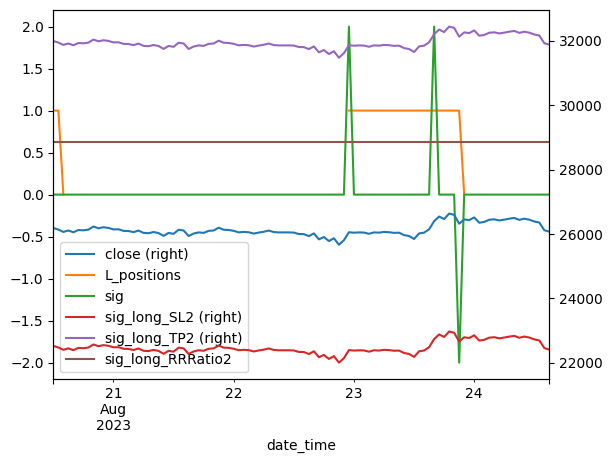

In [10]:
dfmtzTP[["close","L_positions", "sig","sig_long_SL2", "sig_long_TP2","sig_long_RRRatio2"]].tail(100).plot(secondary_y=["close","sig_long_SL2","sig_long_TP2"])

In [ ]:
import importlib
from signal_managers import tide_z_genetic
importlib.reload(tide_z_genetic)

from signal_managers import tide_z_genetic


df0 = tide_z_genetic.initialise_parent(df=None,backtest_window = ["2021-01-01","2023-12-31"],
                      instruments =  [
                                        "ccxt_kucoin__BTC-USDT",
                                        # "ccxt_kucoin__ETH-USDT",
                                        "ccxt_currencycom__US500",
                                        #  "ccxt_currencycom__DXY",
                                        #  "ccxt_currencycom__Gold",
                                        #  "ccxt_currencycom__Oil - Crude",
                                        #   "ccxt_currencycom__NVDA",
                                        #    "ccxt_currencycom__UVXY"
                                        ],
                      timeframes = ["1h"],
                      timeframes_to_resample_to = ["2h","3h","4h","6h","8h","12h"],
                      instrument_to_trade = "ccxt_kucoin__BTC-USDT",
                      timeframe_to_trade = "1h",
                      signal_function = "z_sig",
                      signals_to_trade = "sig",
                      backtest_window = ["2021-01-01","2023-12-31"],
                      sig_lag=0,
                      kline_to_trade = f"close",
                      volume_to_trade= f"volume",
                      fee = 0.001,
                      slippage = 0.0,
                      min_holding_period = 23,
                      max_holding_period = 1e6,
                      long_equity = 5e5,
                      long_notional=5e5,
                      short_equity = 5e5,
                      short_notional= 5e5,
                      show_plots=True, 
                      figsize = (20,15), 
                      chosen_to_debug = ["ccxt_currencycom__US500", "12h"]
                      )

## f) Try for 5minutes or more granular